In [1]:

import sys  
sys.path.insert(0, '/Users/cwilson/desktop/programming/jupyter_tings/healthyride/healthyride')

from trip import Trip
from neighborhood_analytics.neighborhood import Neighborhood

import json



In [2]:
import matplotlib.pyplot as plt
from weekday_analytics.weekday import dayint_to_daystr

import datetime

import matplotlib.dates as mdates

from collections import OrderedDict

In [3]:
with open('../data.json') as f:
  json_list = json.load(f)
 

In [4]:
print(json_list[0])

{'Trip id': '107269366', 'Bikeid': '70529', 'To station name': 'S 18th St & Sidney St', 'Usertype': 'Subscriber', 'Stoptime': '10/1/2020 0:30', 'From station name': 'Atwood St & Bates St', 'Starttime': '10/1/2020 0:13', 'To station id': '1048', 'Tripduration': '1025', '_id': 1, 'From station id': '1039'}


In [5]:
#convert list of dicts to list of objects called "Trips"
Trip_list = []
for dict in json_list:
    li = list(dict.values())
    Trip_list.append(Trip(*li))

In [6]:
#test er out
print(Trip_list[420])
print(Trip_list[420].toname)
print(Trip_list[420].starttime)
print(Trip_list[420].weekday)
print(Trip_list[420].start_neighborhood)

Trip(tripid='107414962', bikeid='70303', toname='Stanton Ave & N Negley Ave', usertype='Customer', stoptime='10/2/2020 17:06', fromname='Butler St & 36th St', starttime='10/2/2020 16:43', toid='49401', tripduration='1357', _id=416, fromid='49951')
Stanton Ave & N Negley Ave
10/2/2020 16:43
4
Lawrenceville


In [7]:
clensed_Trip_list = [i for i in Trip_list if type(i.weekday) is int ]

In [8]:
print(len(clensed_Trip_list))

567472


In [9]:
trip_tuple = Neighborhood.sort_direction_neighborhood_weekday_hour(clensed_Trip_list)

arrivals_by_neighborhood = trip_tuple[0]
departures_by_neighborhood = trip_tuple[1]


In [10]:
# print the 6th day of the week of arrivals by hour in oakland
print(arrivals_by_neighborhood['Oakland'][6])

{'0': Counter({'Oakland': 146, 'Not a station in a defined neighborhood': 32, 'Shadyside': 19, 'Southside Flats': 15, 'Downtown': 6, 'Squirrel Hill': 5, 'East Liberty': 4, 'Lawrenceville': 2, 'North Shore': 2}), '1': Counter({'Oakland': 114, 'Not a station in a defined neighborhood': 31, 'Southside Flats': 15, 'Shadyside': 10, 'East Liberty': 4, 'Lawrenceville': 2, 'Downtown': 2, 'North Shore': 1}), '2': Counter({'Oakland': 63, 'Not a station in a defined neighborhood': 19, 'Southside Flats': 11, 'Shadyside': 8, 'Downtown': 4, 'East Liberty': 2, 'North Shore': 2, 'Strip District': 1, 'Lawrenceville': 1}), '3': Counter({'Oakland': 38, 'Shadyside': 4, 'Not a station in a defined neighborhood': 3, 'East Liberty': 2, 'Downtown': 1}), '10': Counter({'Oakland': 206, 'Not a station in a defined neighborhood': 77, 'Shadyside': 39, 'East Liberty': 18, 'Downtown': 14, 'Southside Flats': 12, 'Squirrel Hill': 7, 'North Shore': 5, 'Lawrenceville': 3, 'Central Northside': 2, 'Strip District': 1}), '

In [11]:
station_dict = {
    'Downtown': ['1000', '49701', '1002', '1001', '49691', '49671', '1056', '1003', 
                                '49731', '1004', '1006', '49651', '1010'],
    
    'Strip District': ['1016', '1017', '49611', '1059', '1060'],

    'East Liberty' : ['1026', '1027', '1029', '1024', '49391', '49371', '1064'],

    'Lawrenceville' : ['1061', '49581', '1019', '1020', '49501', '49951', '49561', '1018'],

    'North Shore' : ['49941', '49921', '1012', '1013'],

    'Central Northside' : ['1014', '1015', '49881'],

    'Southside Flats' : ['1074', '1049', '1048', '1047', '1046', '1045', '1084'],

    'Oakland' : ['1038', '1044', '1039', '1091', '1093', '1041', '1095', '1036', '1037', '1099', 
                        '1040', '1097', '1035', '1094', '49271'],
    
    'Squirrel Hill' : ['49251', '49261', '1068', '1069', '1070'],
    
    'Shadyside': ['1034', '1033', '1032', '1031'] 

}

In [12]:
#function that zips two dictionaries by identical key

def combine_dicts(arrival_dict, departure_dict):
    #order matters, arrivals are first index of tuple, departures follow
    return_dict = {}
    for key in arrival_dict.keys():
        return_dict[key] = (arrival_dict[key], departure_dict[key])
    return return_dict
        

In [13]:
tuple_dict = combine_dicts(arrivals_by_neighborhood, departures_by_neighborhood)

In [14]:

def make_keys_int(d):
    return_dict = {}
    for key in d.keys():
        return_dict[int(key)] = d[key]
    return return_dict


def order_nested_dict(nested_dict):
    return_dict = {}

    for key, val in OrderedDict(sorted(nested_dict.items())).items():
        nested_dict = make_keys_int(val)

        return_dict[key] = OrderedDict(sorted(nested_dict.items()))
    return return_dict

In [15]:
neighborhoods = tuple_dict.keys()


In [16]:
#plotting funcs

def plot_hours_of_day(ax, day_of_wk, daily_dict):
    x = list(range(0, 24))

    x = [datetime.datetime.strptime(str(i),'%H') for i in x]
    
    for key, val in daily_dict.items():

        ax[day_of_wk].title.set_text((dayint_to_daystr(day_of_wk)))

        ax[day_of_wk].xaxis.set_major_locator(plt.MaxNLocator(6))
        ax[day_of_wk].xaxis.set_major_formatter(mdates.DateFormatter("%I"))
        
        ax[day_of_wk].plot(x, val)

        ax[day_of_wk].set_xlabel('Hour of Day')
        #ax.plot(x, val)

    ax[0].set_ylabel('4-year Arrival/Departure Volume')

In [17]:
print(tuple_dict.keys())

dict_keys(['Southside Flats', 'Oakland', 'East Liberty', 'Downtown', 'Not a station in a defined neighborhood', 'Strip District', 'Shadyside', 'Lawrenceville', 'Squirrel Hill', 'North Shore', 'Central Northside'])


In [18]:
def return_arrival_daily_dict(ordered_arrivals, neighborhoods):
    arrival_daily_dict = {}
    for day, val in ordered_arrivals.items():
        neighborhood_dict = {}
        for key, val in val.items():       
            for i in neighborhoods:
                if i not in neighborhood_dict.keys():
                    neighborhood_dict[i] = [val[i]]
                else:
                    neighborhood_dict[i] += [val[i]]
        arrival_daily_dict[day] = neighborhood_dict
    return arrival_daily_dict

In [19]:
def return_departure_daily_dict(ordered_departures, neighborhoods):    
    departure_daily_dict = {}
    for day, val in ordered_departures.items():
        neighborhood_dict = {}
        for key, val in val.items():       
            for i in neighborhoods:
                if i not in neighborhood_dict.keys():
                    neighborhood_dict[i] = [val[i]]
                else:
                    neighborhood_dict[i] += [val[i]]
        departure_daily_dict[day] = neighborhood_dict
    return departure_daily_dict

In [22]:
def plot_daily_dict(direction_statement, neighborhood, daily_dict):
    fig, axs = plt.subplots(1, 7, figsize=(20,3), sharey = True)
    
    for key, val in daily_dict.items():
    #note that at some point here arrivals are flipped with departures

        plot_hours_of_day(axs, key, val)

    
    fig.suptitle(direction_statement + ' ' + neighborhood)

    fig.legend(station_dict.keys(), bbox_to_anchor=(1, 0.84))

    fig.subplots_adjust(top=0.8)
    plt.show()   
    
    

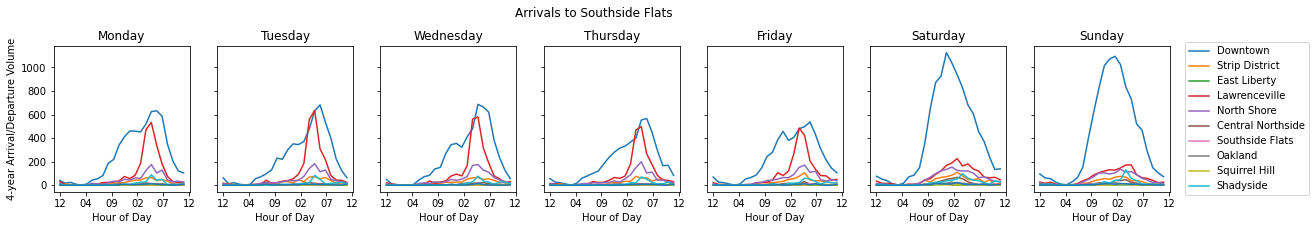

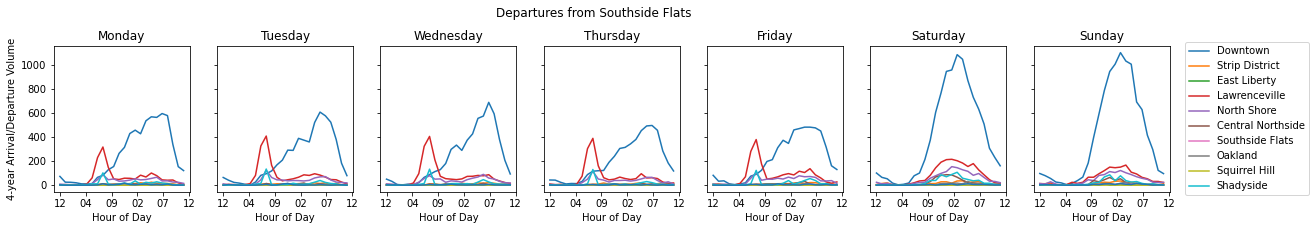

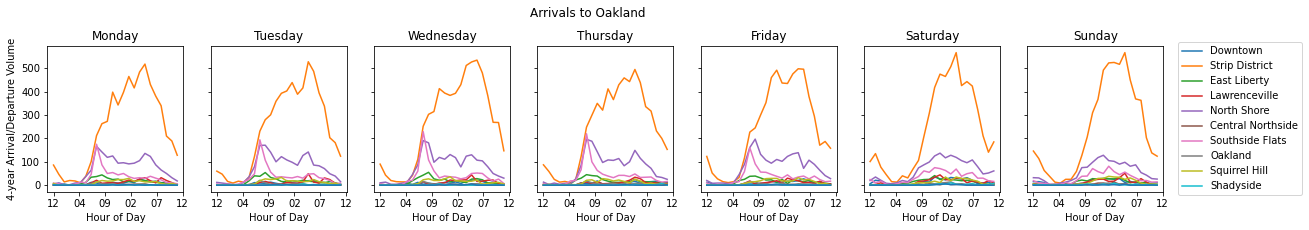

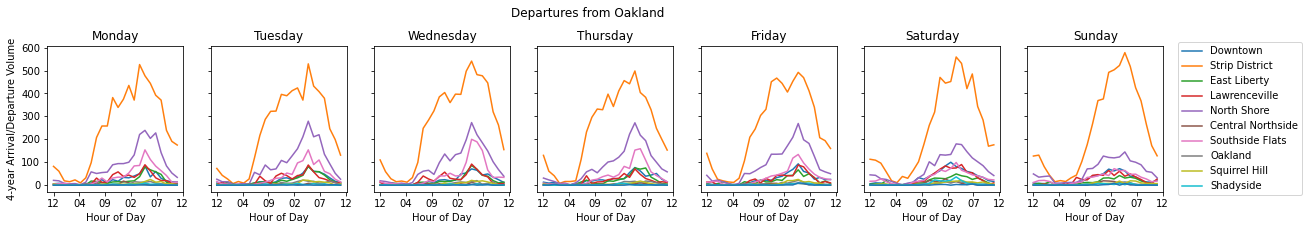

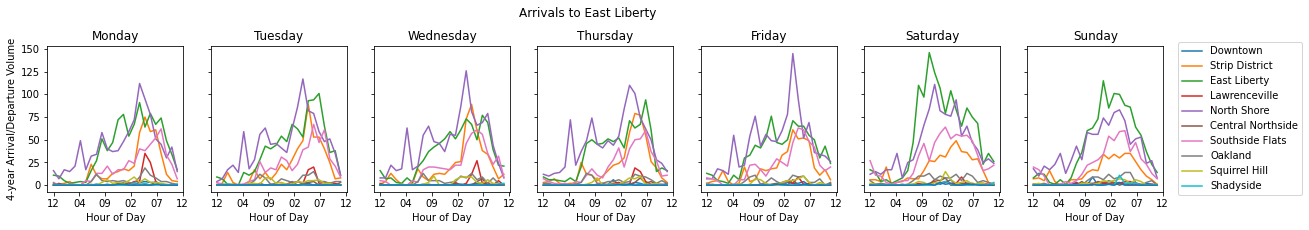

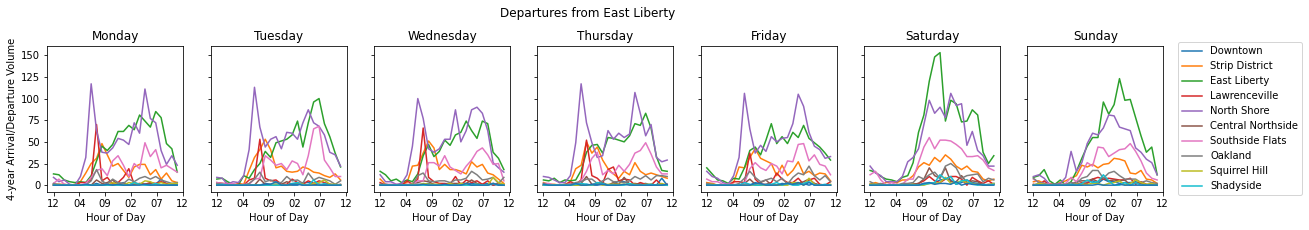

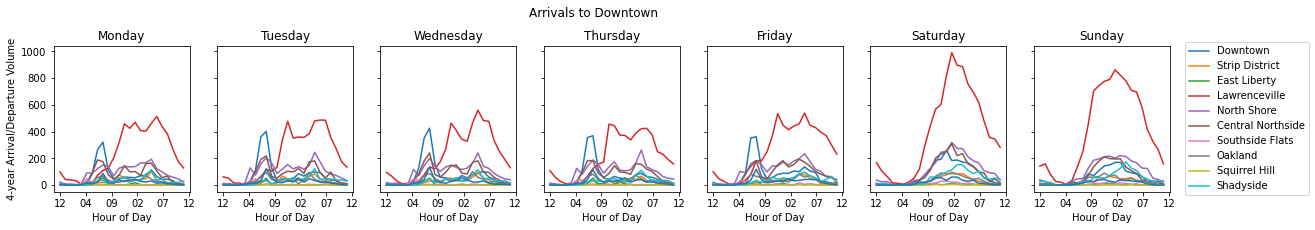

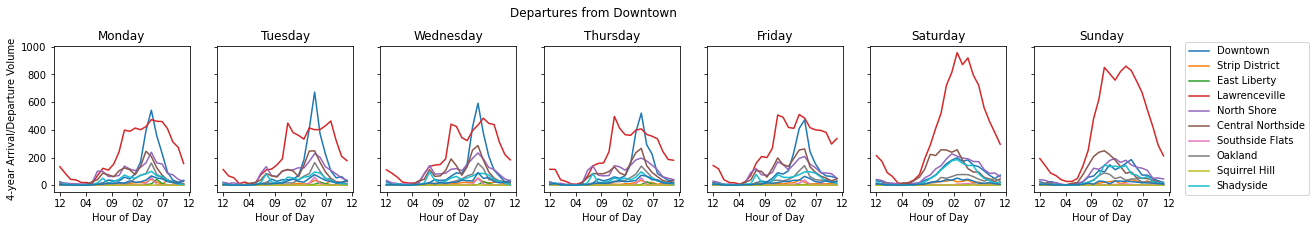

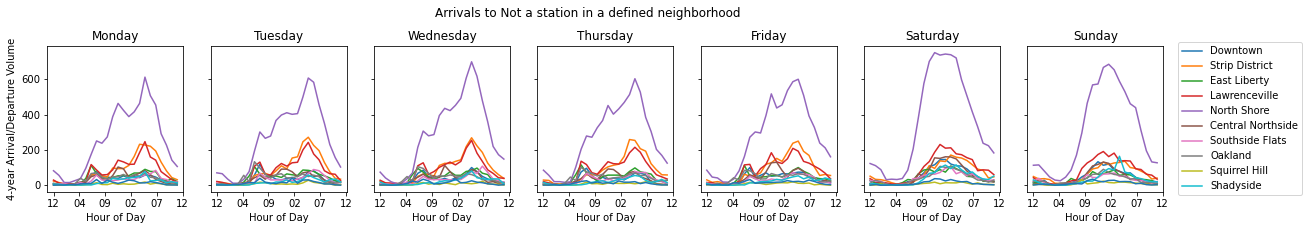

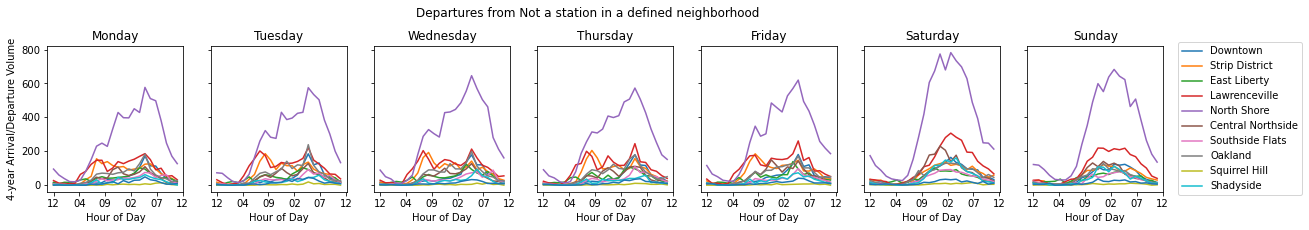

ValueError: x and y must have same first dimension, but have shapes (24,) and (23,)

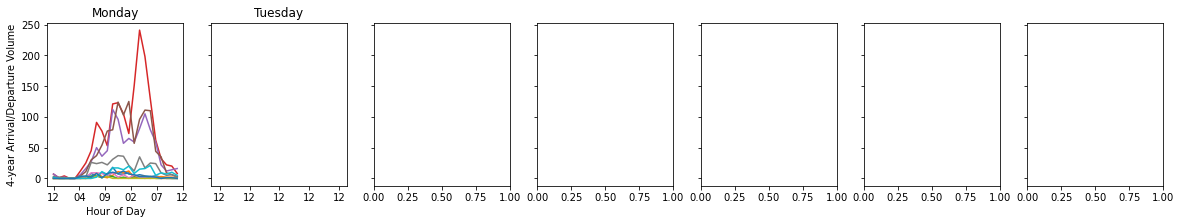

In [24]:

for key, val in tuple_dict.items():
    arrivals, departures = val
    
    ordered_arrivals = order_nested_dict(arrivals)
    ordered_departures = order_nested_dict(departures)

    arrival_daily_dict = return_arrival_daily_dict( ordered_arrivals, neighborhoods)
    departure_daily_dict = return_departure_daily_dict(ordered_departures, neighborhoods)

    plot_daily_dict('Arrivals to', key, arrival_daily_dict)
    plot_daily_dict('Departures from',  key, departure_daily_dict)
    

In [ ]:
def plot_departures(neighborhood, departure_daily_dict):
    fig, axs = plt.subplots(1, 7, figsize=(20,3), sharey = True)
    #note that at some point here arrivals are flipped with departures
    for key, val in departure_daily_dict.items():

        plot_hours_of_day(axs, key, val)

    fig.suptitle(neighborhood)

    fig.legend(station_dict.keys(), bbox_to_anchor=(1, 0.84))

    fig.subplots_adjust(top=0.8)

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(15,2.5), sharey = True)
#note that at some point here arrivals are flipped with departures
for key, val in departure_daily_dict.items():
    plot_hours_of_day(axs, key, val)